# A Short tutorial on accessing and visulizing SWOT L2 LR SSH

Jinbo Wang 

9/7/2023


Disclaimer: The project is still in the process of reprocessing the data. The SWOT data should not be used for scientific analyses. The following code is intended to demonstrate basic data access, processing, and visualization.

You need to download the SWOT KaRIn Expert product in order to run the following example. 

<xarray.Dataset>
Dimensions:                                (num_lines: 626, num_pixels: 69,
                                            num_sides: 2)
Coordinates:
    latitude_nadir                         (num_lines) float64 33.01 ... 43.98
    longitude_nadir                        (num_lines) float64 233.9 ... 237.1
    latitude                               (num_lines, num_pixels) float64 33...
    longitude                              (num_lines, num_pixels) float64 23...
Dimensions without coordinates: num_lines, num_pixels, num_sides
Data variables: (12/96)
    time                                   (num_lines) datetime64[ns] ...
    time_tai                               (num_lines) datetime64[ns] ...
    ssh_karin                              (num_lines, num_pixels) float64 ...
    ssh_karin_qual                         (num_lines, num_pixels) float64 ...
    ssh_karin_uncert                       (num_lines, num_pixels) float32 ...
    ssha_karin                             (num_lines, num_pixels) float64 ...
    ...                                     ...
    sea_state_bias_cor                     (num_lines, num_pixels) float32 ...
    sea_state_bias_cor_2                   (num_lines, num_pixels) float32 ...
    swh_ssb_cor_source                     (num_lines, num_pixels) float32 ...
    swh_ssb_cor_source_2                   (num_lines, num_pixels) float32 ...
    wind_speed_ssb_cor_source              (num_lines, num_pixels) float32 ...
    wind_speed_ssb_cor_source_2            (num_lines, num_pixels) float32 ...
Attributes: (12/60)
    Conventions:                                   CF-1.7
    title:                                         Level 2 Low Rate Sea Surfa...
    source:                                        Ka-band radar interferometer
    history:                                       2023-08-24T21:35:04Z : Cre...
    platform:                                      SWOT
    reference_document:                            D-56407_SWOT_Product_Descr...
    ...                                            ...
    ellipsoid_flattening:                          0.0033528106647474805
    institution:                                   JPL
    references:                                    V1.1
    equator_time:                                  2023-04-23T04:46:35.954000Z
    equator_longitude:                             -131.84
    product_version:                               01

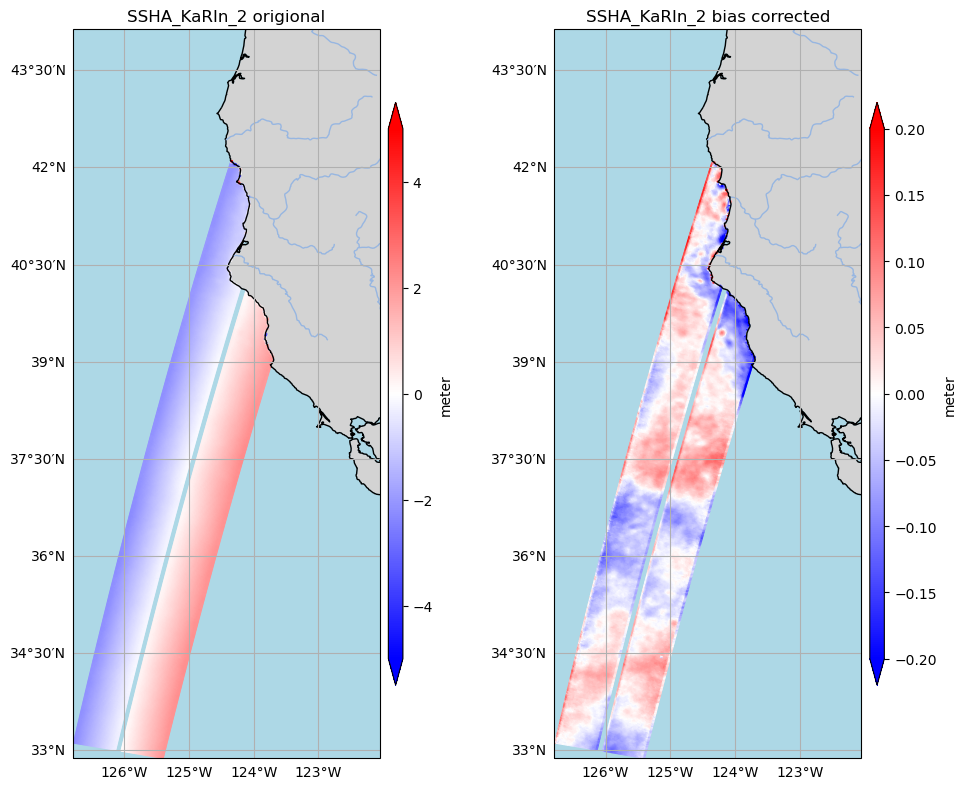

In [22]:
import pylab as plt
import numpy as np
import swot_ssh_utils as swot
import cartopy.crs as ccrs
import cartopy.feature as cfeature


def plotit(ax,lon,lat,dat,title='',
           vmin=-0.15,vmax=0.15):
    proj = ccrs.PlateCarree()
    extent = [lon.min(),lon.max(), lat.min(),lat.max()]
    # Add the scatter plot
    lon=lon.flatten()
    lat=lat.flatten()
    im=ax.scatter(lon, lat, c=dat, s=1, cmap=plt.cm.bwr,
               transform=ccrs.PlateCarree(),
              vmin=vmin,vmax=vmax )
    # Add the colorbar
    cbar = plt.colorbar(im, ax=ax, orientation='vertical', 
                        pad=0.02, aspect=40, shrink=0.8,
                        extend='both' , label='meter')
    ax.coastlines(resolution='10m')
    ax.add_feature(cfeature.LAND, color='lightgrey')
    ax.add_feature(cfeature.OCEAN, color='lightblue')
    ax.add_feature(cfeature.RIVERS)
    gl=ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
    gl.top_labels = gl.right_labels = False
    ax.set_extent(extent, proj)
    ax.set_title(title)
    return

#Use Expert product, which includes the cross_track_distance variable that is needed for bias correction
pth='/home/wangjinb/swot/KaRIn/SWOT_L2_LR_SSH_1.1/'
fn='SWOT_L2_LR_SSH_Expert_499_013_20230423T042206_20230423T051104_PIB0_01.nc'

data=swot.SSH_L2()
data.load_data(pth+fn,lat_bounds=[33,44])
display(data.Expert)
ssha=data.Expert.ssha_karin_2
flag=data.Expert.ancillary_surface_classification_flag 
ssha=np.where(flag==0,ssha,np.nan)
lon=data.Expert.longitude.values
lat=data.Expert.latitude.values
distance=data.Expert.cross_track_distance.values

fig, ax = plt.subplots(figsize=(10,8),ncols=2,nrows=1,sharex=True,sharey=True,
                          subplot_kw=dict(projection=ccrs.PlateCarree()))
plotit(ax[0],lon,lat,ssha,title='SSHA_KaRIn_2 origional', 
       vmin=-5,vmax=5)
ssha_1=swot.fit_bias(ssha, distance, check_bad_point_threshold=0.1,
                           remove_along_track_polynomial=True)
plotit(ax[1],lon,lat,ssha_1,title='SSHA_KaRIn_2 bias corrected', 
       vmin=-0.2,vmax=0.2)

plt.tight_layout()
plt.savefig('../media/figures/ssha_karin_2_california.png',dpi=100)